In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import os
import random
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_moedel = True #@param {type: "boolean"}

In [ ]:
# Dataset specific parameters
folder_path = "/content/drive/MyDrive/eCAADe2025 Workshop"#@param {type: "string"}

dataset_folder = folder_path + "/datasets/NURBS_dataset"

is_poly_surface = True #@param {type: "boolean"}
except_data_shape = (8,3,4,4) #@param
use_padded_data = True #@param {type: "boolean"}


save_model = True #@param {type: "boolean"}
save_model_location = folder_path + "/_models"
# create save_model_location if it doens not exist
if not os.path.exists(save_model_location):
    os.makedirs(save_model_location)

save_model_name = "VAE_NURBS" #@param {type: "string"}
model_name = save_model_name

save_geo_folder = folder_path + "/_geometries/NURBS"
if not os.path.exists(save_geo_folder):
    os.makedirs(save_geo_folder)
save_geo_name = "VAE_NURBS_geo" #@param {type: "string"}




In [ ]:
model_type = "VAE" #@param ["VAE", "AE"] {allow-input: true}

# for VAE only
kld_multiplier = 0.5 #@param {type: "number"}

In [ ]:
# hyperparameters
batch_size = 32 #@param {type: "number"}
epochs = 500 #@param {type: "number"}
train_test_split = 0.9 #@param {type: "number"}

learning_rate = 0.00001 #@param {type: "number"}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("sellected device", device)
if str(device) == "cuda":
    print("CUDA is available")
else:
    print("CUDA is not available - choose a GPU Hardware to speed up AI training")

sellected device cuda
CUDA is not available - choose a GPU Hardware to speed up AI training


In [ ]:
def visualize_points(tensor, point_color = 'b', remove_padding = True, remove_threshold = -0.5):
    # ensure that the tensor is a numpy array if it is a torch tensor convert it to numpy
    if isinstance(tensor, torch.Tensor):
        # put the tensor on the cpu
        tensor = tensor.cpu()
        tensor = tensor.detach().numpy()

    if len(tensor.shape) == 3:
        visualize_surface(tensor, point_color, remove_padding, remove_threshold)
    elif len(tensor.shape) == 4:
        visualize_poly_surface(tensor, point_color, remove_padding, remove_threshold)
    else:
        raise ValueError("The input tensor must have main shape of 3 or 4")


def visualize_surface(tensor, point_color, remove_padding, remove_threshold):

    if tensor.shape[0] == 4:
    #detach the last matrix from the tensor
        tensor = tensor[0:3, :]
    elif tensor.shape[0] != 3:
        raise ValueError("The input tensor must have main shape of 3 or 4")

    tensor = tensor.reshape(3, -1).T

    if remove_padding:
        #remove all rows and columns that are all -1s
        tensor = tensor[~np.all(tensor < remove_threshold, axis=1)]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tensor[:, 0], tensor[:, 1], tensor[:, 2], c=point_color)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    plt.show()


def visualize_poly_surface(tensor, point_color, remove_padding, remove_threshold):
    if tensor.shape[1] == 4:
        #detach the last matrix from the tensor
        tensor = tensor[:,0:3,:,:]
        print(tensor.shape)
    elif tensor.shape[1] != 3:
        raise ValueError("The input tensor must have main shape of 3 or 4")

    poly_surface = []
    for surface in tensor:
        surface = surface.reshape(3, -1).T

        if remove_padding:
            #remove all rows and columns that are all -1s
            surface = surface[~np.all(surface < remove_threshold, axis=1)]

        #print(surface.shape)
        if surface.shape[0] > 0:
            poly_surface.append(surface)

    poly_surface = np.array(poly_surface).reshape(-1, 3)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(poly_surface[:, 0],poly_surface[:, 1],poly_surface[:, 2], c=point_color)
    # fix the x,y,z limits from 0 to 1
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    plt.show()


In [ ]:
def visualize_heatmaps(array_3d, save_path=None):

    # If array is an instance of torch tensor, convert it to numpy
    if isinstance(array_3d, torch.Tensor):
        array_3d = array_3d.cpu().detach().numpy()

    def surface_heat_map(array_3d, num_iterations, figsize=(15, 5)):
        fig, axes = plt.subplots(num_iterations, 3, figsize=(15, 5 * num_iterations))
        cmap = plt.cm.viridis
        cmap.set_bad(color='black')  # Set color for masked values

        # Ensure axes is always a 2D array for consistent indexing
        if num_iterations == 1:
            axes = np.expand_dims(axes, axis=0)

        for i in range(num_iterations):
            for j in range(3):
                slice_2d = array_3d[i, j]

                # Create a masked array where -1 values are masked
                masked_slice = np.ma.masked_where(slice_2d == -1, slice_2d)

                ax = axes[i, j]
                im = ax.imshow(masked_slice, cmap=cmap, vmin=-1, vmax=1)
                ax.set_title(f'Iteration {i+1}, Slice {["X", "Y", "Z"][j]}')
                fig.colorbar(im, ax=ax)

        # Set tight layout
        plt.tight_layout()

        # Set title
        plt.suptitle('Heatmap Slices', fontsize=16)

        if save_path:
            plt.savefig(os.path.join(save_path, 'heatmap_slices.png'))
        else:
            plt.show()
        plt.close()

    if len(array_3d.shape) == 3:
        if array_3d.shape[0] == 4:
            # Detach the last matrix from the tensor
            array_3d = array_3d[0:3, :]
        elif array_3d.shape[0] != 3:
            raise ValueError("The input tensor must have main shape of 3 or 4")

        surface_heat_map(array_3d[np.newaxis, :], 1)  # Add a new axis to make it 4D

    elif len(array_3d.shape) == 4:
        if array_3d.shape[1] == 4:
            # Detach the last matrix from the tensor
            array_3d = array_3d[:, 0:3, :]
        elif array_3d.shape[1] != 3:
            raise ValueError("The input tensor must have main shape of 3 or 4")

        surface_heat_map(array_3d, array_3d.shape[0])  # Pass the number of iterations

    else:
        raise ValueError("The input tensor is not Surface or Poly Surface")

# Example usage
# Assuming data is of shape (num_iterations, 3, height, width)
#num_iterations = 1
#height, width = 16, 16
#data = np.random.rand(num_iterations, 3, height, width)

#visualize_heatmaps(data)

Number of training samples: 2729
Number of testing samples: 304
Shape of the data:  torch.Size([8, 3, 4, 4])
Type of the data:  <class 'torch.Tensor'>


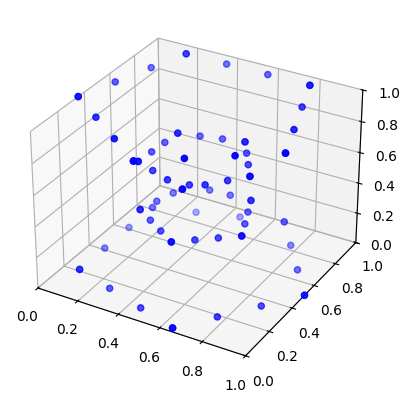

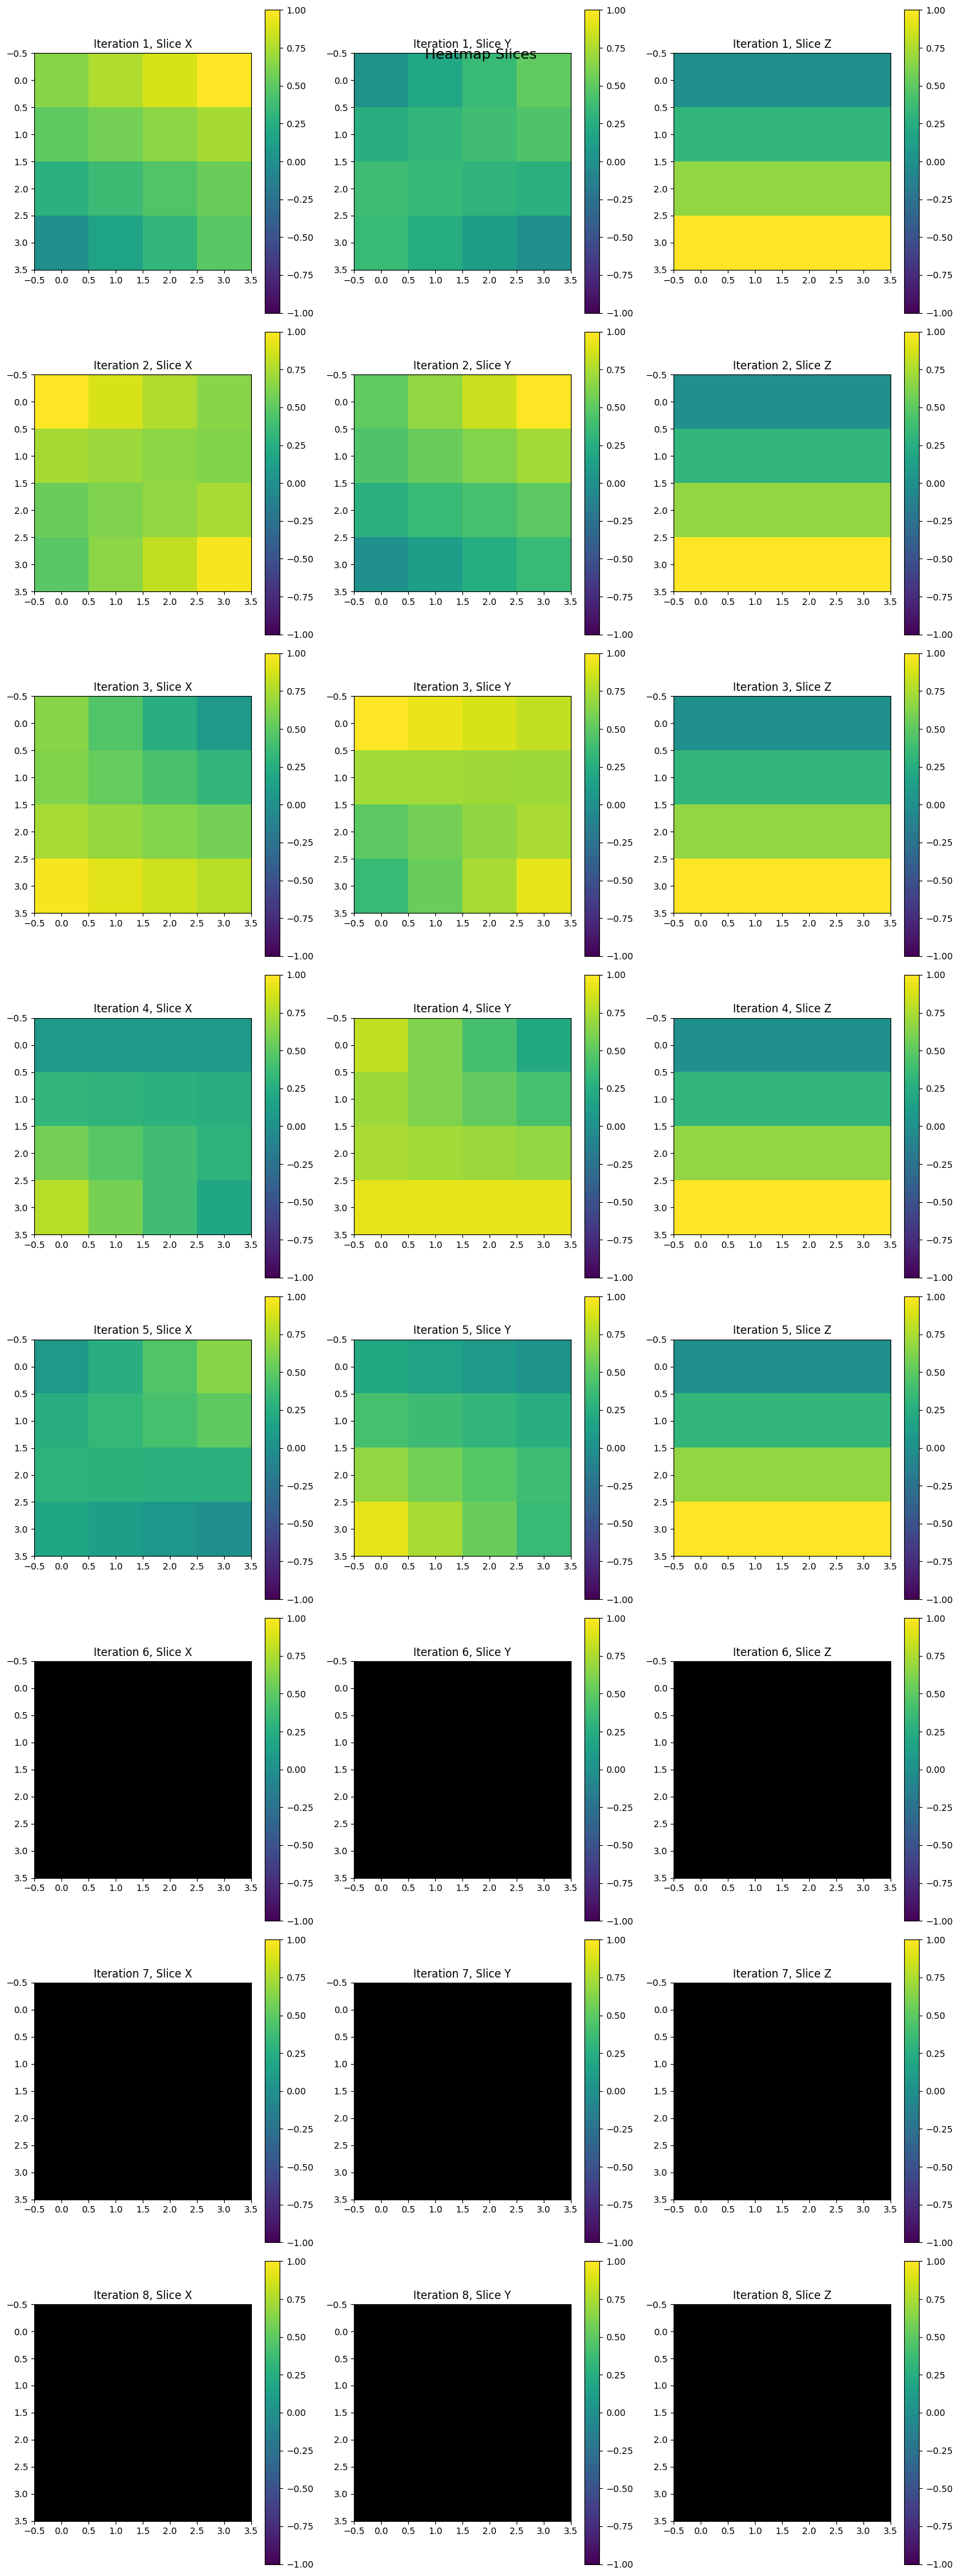

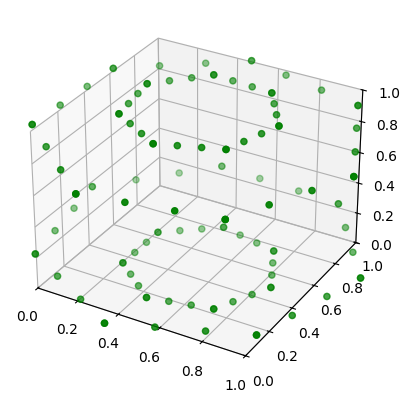

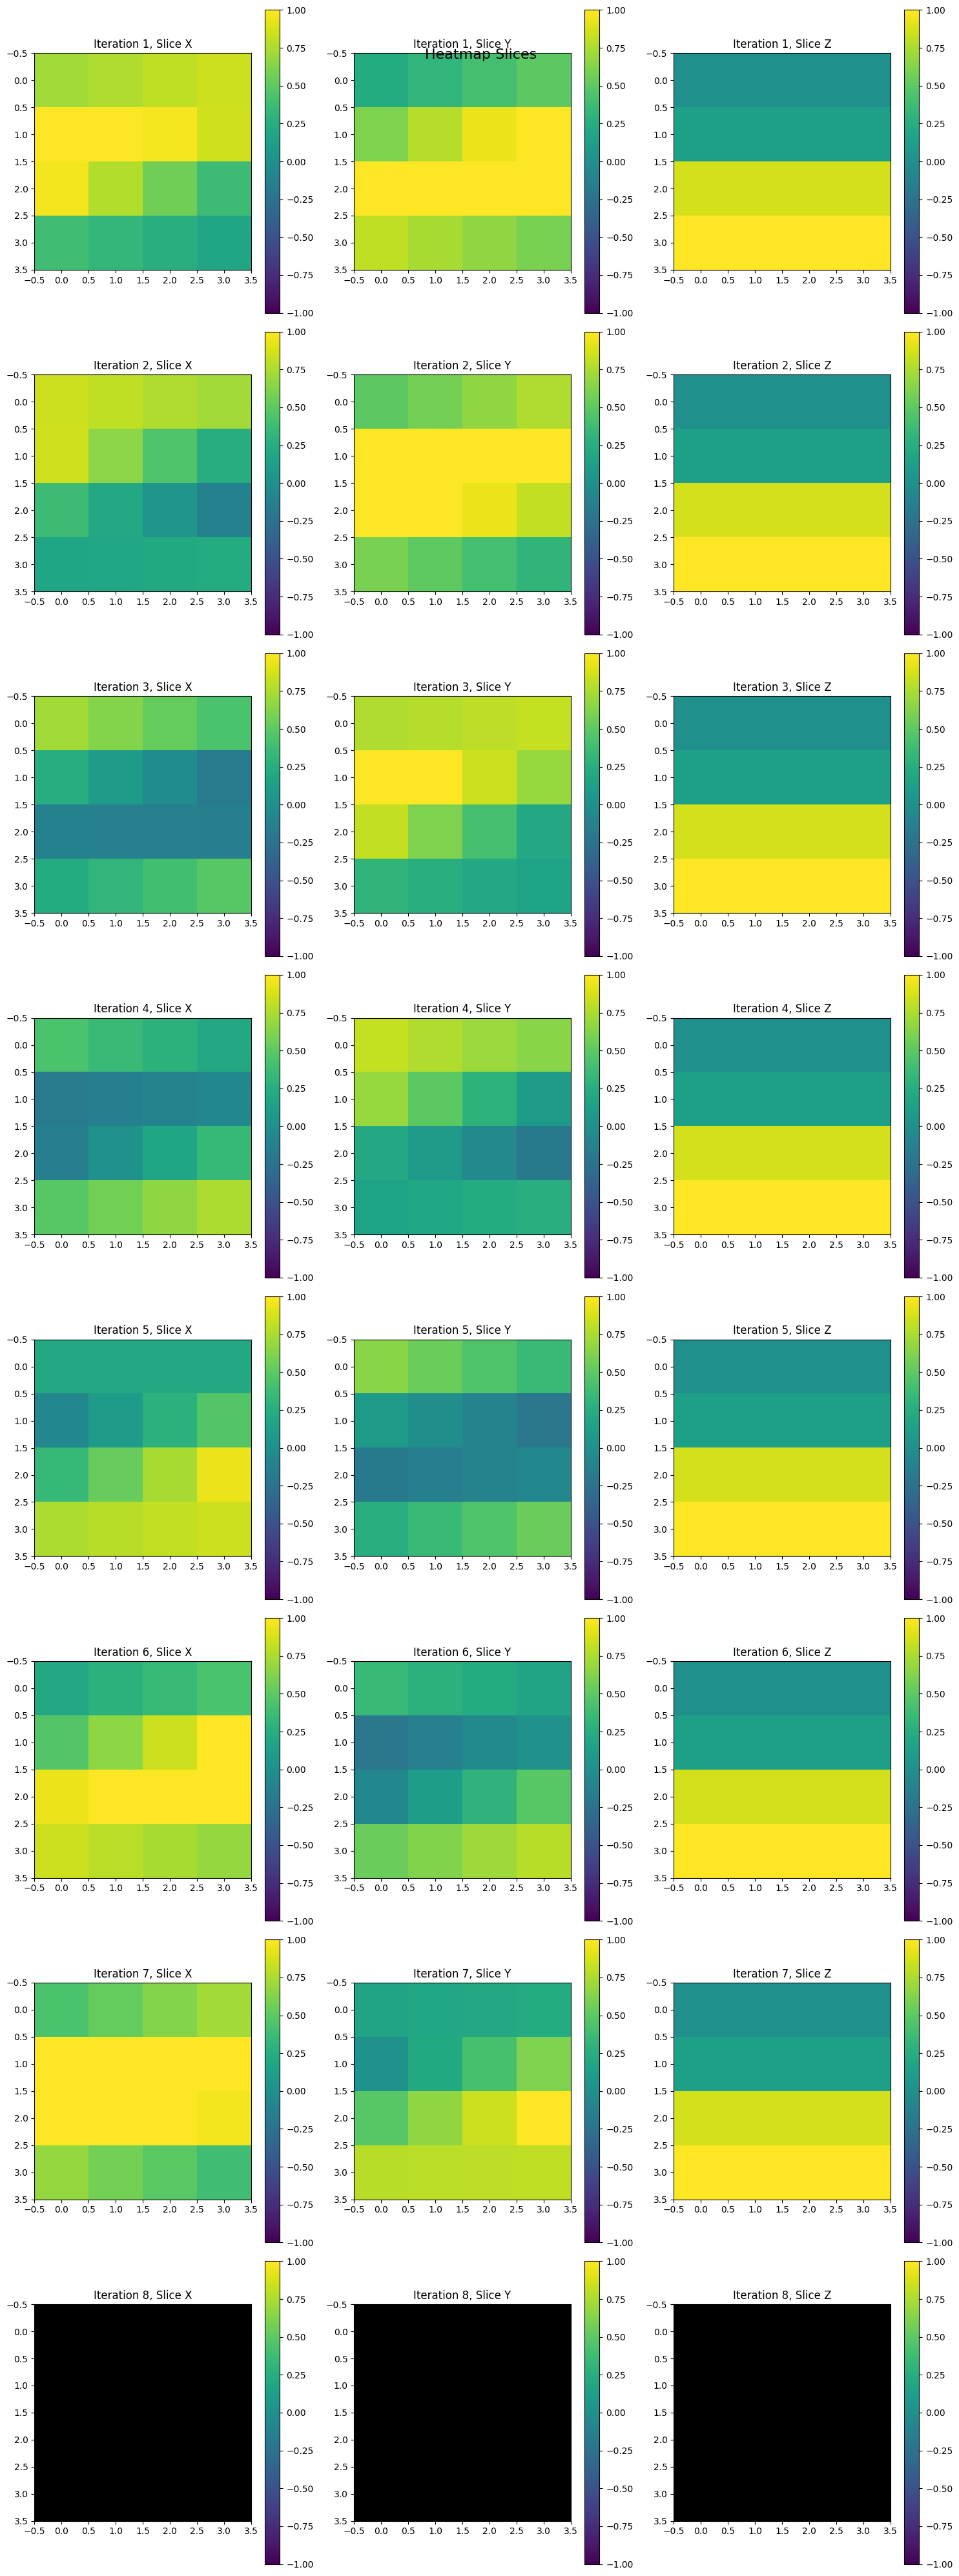

In [ ]:
test_data_percent = 1.0 - train_test_split

def dataloader(folder_path, expected_shape):
    data = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                item = np.load(file_path)
                if item.shape == expected_shape:
                    data.append(item)
                else:
                    print(f"Skipping file {file} due to unexpected shape: {item.shape}")
    return data

# test dataloader

data = dataloader(dataset_folder, except_data_shape)

# split the data into train and test
random.shuffle(data)
train_data = data[:int(train_test_split*len(data))]
test_data = data[int(train_test_split*len(data)):]

#conveert the data to torch tensors and put them on the device
train_data = torch.tensor(train_data, dtype=torch.float32, device=device)
test_data = torch.tensor(test_data, dtype=torch.float32, device=device)

# Create TensorDatasets
train_dataset = TensorDataset(train_data)
test_dataset = TensorDataset(test_data)

# Create DataLoaders with shuffle=True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of testing samples: {len(test_data)}")

# print some information about the data
random_index = random.randint(0, len(train_data))
print('Shape of the data: ', train_data[random_index].shape)
print('Type of the data: ', type(train_data[random_index]))
visualize_points(train_data[random_index])

visualize_heatmaps(train_data[random_index])

visualize_points(test_data[0], point_color='g')
visualize_heatmaps(test_data[0])
#print(test_data[0])

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_shape=(3, 16, 16), hidden_dims=[600,300,], latent_dim=64, dropput_rate = 0.1, device=device):
        super(VAE, self).__init__()

        if len(input_shape) == 3:
            input_dim = input_shape[0] * input_shape[1] * input_shape[2]
        elif len(input_shape) == 4:
            input_dim = input_shape[0]* input_shape[1] * input_shape[2] * input_shape[3]
        else:
            raise ValueError("The input shape must be of length 3 or 4")

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[1], latent_dim),
            nn.ReLU(True),
            nn.Dropout(dropput_rate)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)


        if use_padded_data == True:
            self.final_activation = nn.Tanh()
        else:
            self.final_activation = nn.Sigmoid()

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(latent_dim, hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropput_rate),

            nn.Linear(hidden_dims[0], input_dim),
            self.final_activation
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        #print(x.shape)

        mean, logvar = self.encode(x)
        #print(mean.shape, logvar.shape)

        z = self.reparameterization(mean, logvar)
        #print("z", z.shape)
        x_hat = self.decode(z)
        #print("output shape", x_hat.shape)
        return x_hat, mean, logvar

if model_type == "VAE":
    model = VAE(input_shape=except_data_shape).to(device)
    x = torch.randn(batch_size, *except_data_shape).to(device)
    x = x.view(batch_size, -1)

    x_hat, mean, logvar = model(x)
    print(x_hat.shape)
    print(mean.shape)
    print(logvar.shape)

    print("Number of parameters in the model: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    print("Number of layers in the model: ", len(list(model.parameters())))

torch.Size([32, 384])
torch.Size([32, 64])
torch.Size([32, 64])
Number of parameters in the model:  873928
Number of layers in the model:  18


In [ ]:
class AE(nn.Module):

    def __init__(self, input_shape=(3, 16, 16), hidden_dims=[800, 700], latent_dim=600, dropout_rate=0.1, device='cpu'):
        super(AE, self).__init__()

        if len(input_shape) == 3:
            input_dim = input_shape[0] * input_shape[1] * input_shape[2]
        elif len(input_shape) == 4:
            input_dim = input_dim[0] *input_shape[1] * input_shape[2] * input_shape[3]
        else:
            raise ValueError("The input shape must be of length 3 or 4")


        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[1], latent_dim),
            nn.ReLU(True),
            nn.Dropout(dropout_rate)
        )

        if use_padded_data == True:
            self.final_activation = nn.Tanh()
        else:
            self.final_activation = nn.Sigmoid()

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[1]),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),

            nn.Linear(hidden_dims[0], input_dim),
            #nn.Tanh()
            self.final_activation
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        #print(x.shape)
        z = self.encode(x)
        #print(z.shape)
        x_hat = self.decode(z)
        #print(x_hat.shape)
        return x_hat

# Example usage
if model_type == "AE":
    input_shape = except_data_shape
    model = AE(input_shape=input_shape, hidden_dims=[800, 700], latent_dim=600, dropout_rate=0.1, device='cpu')
    x = torch.rand(2, *input_shape)  # Example input
    # flatten the input
    x = x.view(x.size(0), -1)
    print("Input shape:", x.shape)
    x_hat = model(x)
    print("Reconstructed shape:", x_hat.shape)

In [ ]:
if model_type == "VAE":

    model = VAE(input_shape=except_data_shape).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Constrcting a VAE model")
    print(model)

Constrcting a VAE model
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=384, out_features=600, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=300, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
  )
  (mean_layer): Linear(in_features=64, out_features=64, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=64, bias=True)
  (final_activation): Tanh()
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=300, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.

In [ ]:
if model_type == "AE":

    model = AE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    print("Constrcting a AE model")
    print(model)

In [ ]:
def loss_function(x, x_hat, mean, log_var, kld_multiplier=1.0):
    # Reconstruction loss (Mean Squared Error)
    reproduction_loss = F.mse_loss(x_hat, x, reduction='sum')

    # Kullback-Leibler Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # Total loss
    loss = reproduction_loss + KLD * kld_multiplier
    return loss

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    all_losses = []
    all_test_losses = []
    for epoch in range(epochs):
        overall_loss = 0
        #for input_data in train_loader:
        for idx, data in enumerate(train_loader):
            model.train()
            x = data[0].to(device)
            #flatten the input data
            x = x.view(x.size(0), -1)

            optimizer.zero_grad()

            if model_type == "VAE":
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)

            elif model_type == "AE":
                x_hat = model(x)
                loss = F.mse_loss(x_hat, x, reduction='sum')
            else:
                raise ValueError("Model type must be either VAE or AE")

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        # perform validation on the test data
        model.eval()

        with torch.no_grad():
            test_loss = 0
            for idx, data in enumerate(test_loader):

                x = data[0].to(device)
                x = x.view(x.size(0), -1)

                if model_type == "VAE":
                    x_hat, mean, log_var = model(x)
                    loss = loss_function(x, x_hat, mean, log_var)
                elif model_type == "AE":
                    x_hat = model(x)
                    loss = F.mse_loss(x_hat, x, reduction='sum')
                else:
                    raise ValueError("Model type must be either VAE or AE")

                test_loss += loss.item()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss / len(train_loader.dataset), "Validation Loss: ", test_loss / len(test_loader.dataset))
        all_losses.append(overall_loss / len(train_loader.dataset))
        all_test_losses.append(test_loss / len(test_loader.dataset))

    return all_losses, all_test_losses
if train_moedel == True:
    overall_loss, validation_loss =train(model, optimizer, epochs=epochs, device=device)

    if save_model:
        torch.save(model, os.path.join(save_model_location, model_name))
        #wait 5 seconds
        time.sleep(5)
        print("Model saved to: ", os.path.join(save_model_location, model_name))

	Epoch 1 	Average Loss:  217.87552071106919 Validation Loss:  217.47692389237253
	Epoch 2 	Average Loss:  209.33749820182243 Validation Loss:  202.7952511436061
	Epoch 3 	Average Loss:  173.58993146706956 Validation Loss:  139.25101511101974
	Epoch 4 	Average Loss:  125.64002824659616 Validation Loss:  108.92541985762746
	Epoch 5 	Average Loss:  108.03307255583833 Validation Loss:  98.33338807758533
	Epoch 6 	Average Loss:  100.3239629122747 Validation Loss:  92.77127235814145
	Epoch 7 	Average Loss:  95.71502455183332 Validation Loss:  88.67689514160156
	Epoch 8 	Average Loss:  92.08193360269615 Validation Loss:  85.27838616622121
	Epoch 9 	Average Loss:  88.63779685138215 Validation Loss:  81.30442850213302
	Epoch 10 	Average Loss:  84.30642772882838 Validation Loss:  75.50806005377518
	Epoch 11 	Average Loss:  77.18360211465681 Validation Loss:  66.58957150107936
	Epoch 12 	Average Loss:  67.99149200338809 Validation Loss:  56.99800190172697
	Epoch 13 	Average Loss:  59.297287227732

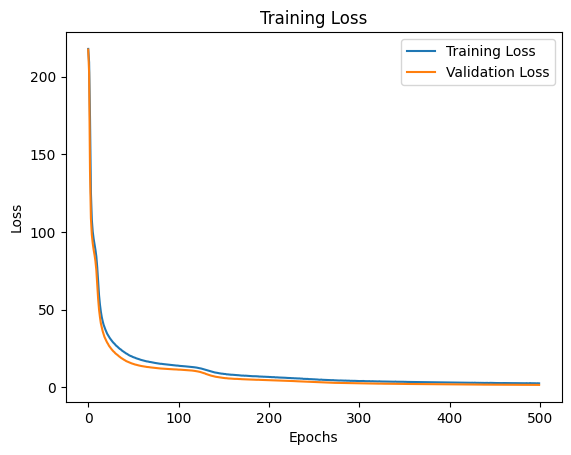

In [ ]:
if train_moedel == True:
    #plot the loss
    plt.plot(overall_loss)
    plt.plot(validation_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

torch.Size([1, 8, 3, 4, 4])


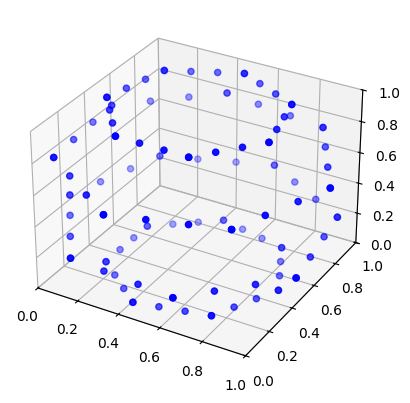

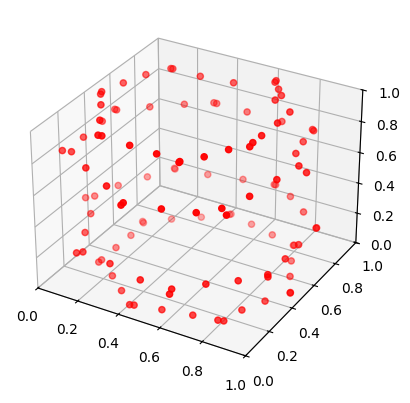

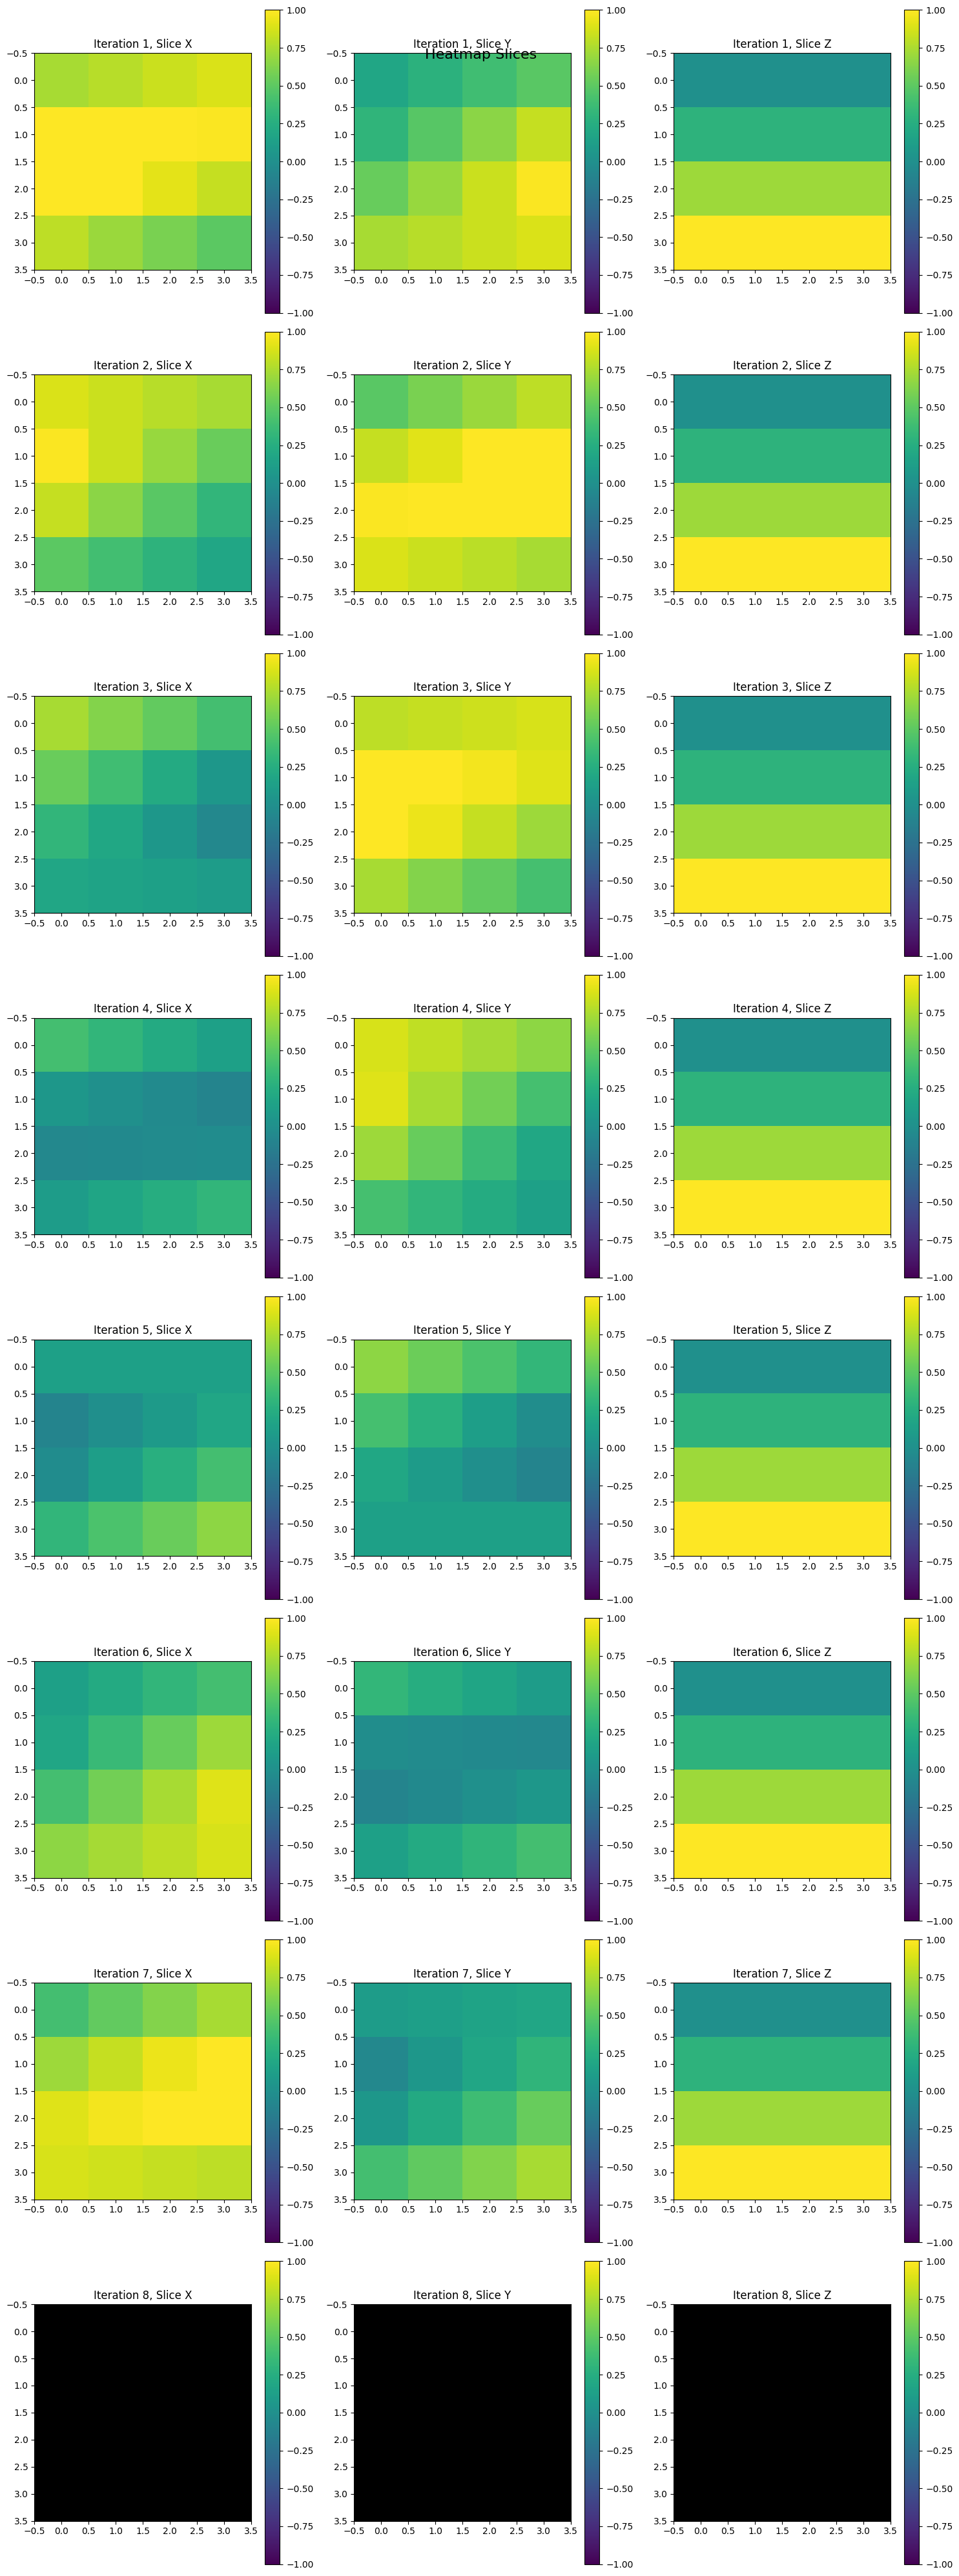

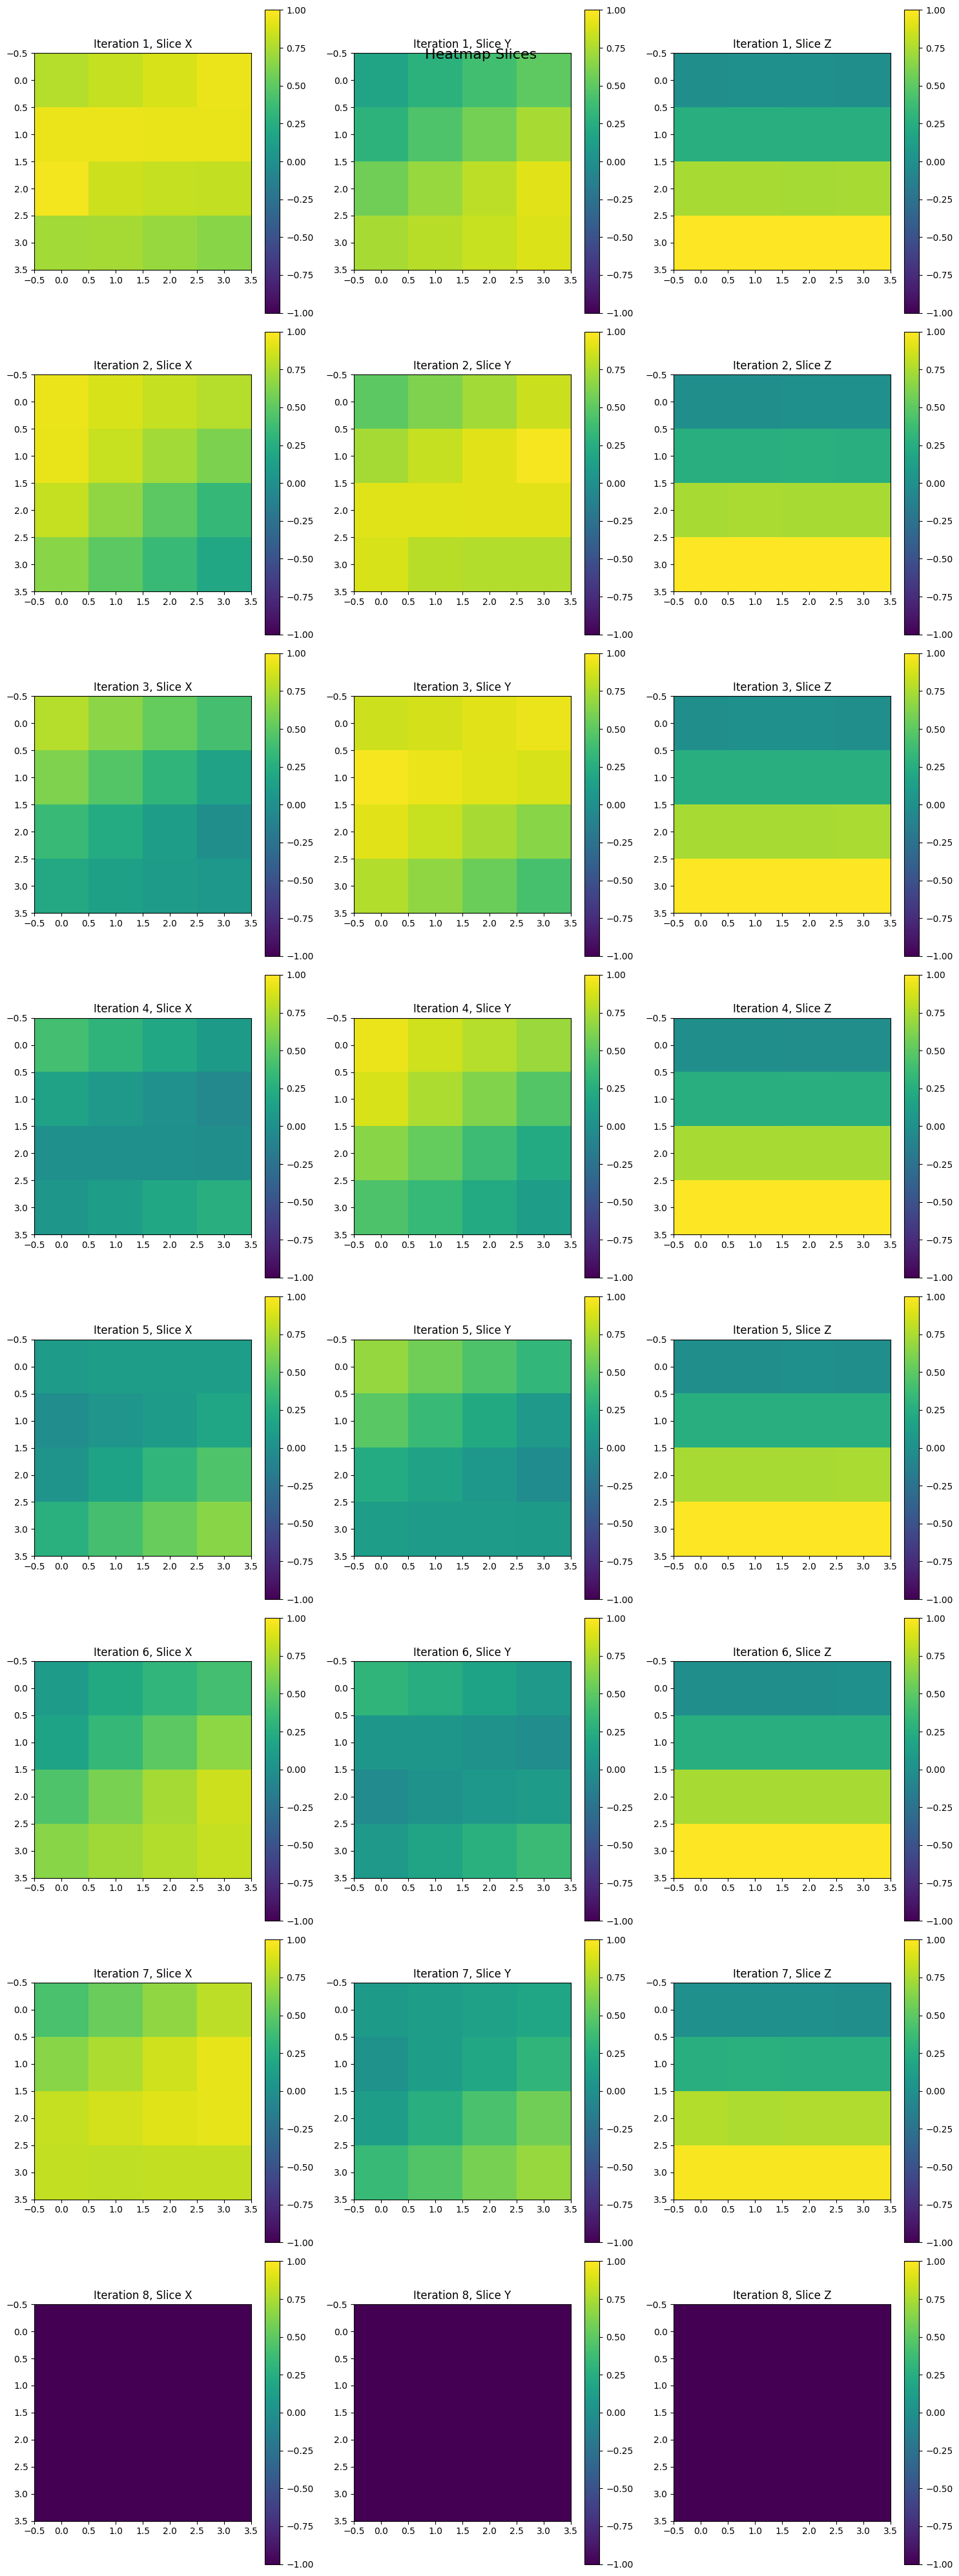

In [ ]:
if train_moedel == True:
    # put the model in evaluation mode
    random_index = random.randint(0, len(test_data))

    model.eval()


    # perform reconstruction on the test data
    test_sample = test_data[random_index].unsqueeze(0)

    test_sample_flatten = torch.flatten(test_sample, start_dim=1)

    # AE
    if model_type == "AE":
        test_prediction = model(test_sample_flatten)

    #VAe
    if model_type == "VAE":
        test_prediction, _, _ = model(test_sample_flatten)

    test_prediction = test_prediction.view(test_sample.shape)
    print(test_prediction.shape)
    if is_poly_surface == True:
    #remove first dimension
        test_sample = test_sample.squeeze(0)
        test_prediction = test_prediction.squeeze(0)

    visualize_points(test_sample)
    visualize_points(test_prediction, point_color='r')

    visualize_heatmaps(test_sample)
    visualize_heatmaps(test_prediction)

In [ ]:
# load the saved model
loaded_model = torch.load(os.path.join(save_model_location, model_name), weights_only=False)
loaded_model.eval()

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=384, out_features=600, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=600, out_features=300, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=300, out_features=64, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
  )
  (mean_layer): Linear(in_features=64, out_features=64, bias=True)
  (logvar_layer): Linear(in_features=64, out_features=64, bias=True)
  (final_activation): Tanh()
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=300, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=300, out_features=600, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.1, inplace=False)
    (9

In [ ]:
# generate 10 new laten space points
number_of_new_geometry_to_generate = 20 #@param {type: "number"}
if model_type == "VAE":
    for i in range(number_of_new_geometry_to_generate):
        z = torch.randn(1, 64).to(device)
        #print(z.shape)
        x_hat = loaded_model.decode(z)
        x_hat = x_hat.view(1, *except_data_shape)
        #visualize_points(x_hat[0], point_color='purple')
        #visualize_heatmaps(x_hat[0])
        #convert the tensor to numpy
        x_hat_numpy = x_hat.cpu().detach().numpy()
        x_hat_numpy = x_hat_numpy.squeeze(0)
        print("Geometry exported with shape", x_hat_numpy.shape)

        np.save(os.path.join(save_geo_folder, save_geo_name + str(i)+".npy"), x_hat_numpy)

Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)
Geometry exported with shape (8, 3, 4, 4)


Latent space shape: (304, 64)
Latent space mean: [-4.0445194e-02  3.4486938e-02  3.0303139e-02  4.5381453e-02
 -6.7471280e-03 -3.2430101e-02  4.2674605e-02 -2.7387569e-02
 -2.2148218e-02  2.3146961e-03 -5.2092947e-02  2.7941851e-02
 -3.9559107e-02  3.4197561e-02 -2.2450725e-02 -5.3569429e-02
 -1.6471963e-02  5.1002342e-02  4.3694340e-02  1.1664898e-02
 -3.1293467e-02  3.3103507e-02  5.3846084e-02  4.7534524e-04
  1.6383374e-02 -6.7486702e-03 -1.6685297e-03  5.6917492e-02
 -1.5775271e-03  1.7010670e-02 -1.3516219e-02 -2.3421153e-02
  3.3268116e-02  1.6907930e-02  4.1717329e-04  1.6129840e-02
 -1.6406514e-02  3.0109957e-02  2.7236719e-02 -1.4786428e-03
  2.4652874e-02  1.9693596e-02 -3.4851834e-02 -8.2420260e-03
  2.4855781e-02 -1.6113250e-03 -8.5869962e-03  4.4044271e-02
 -1.3394911e-03 -3.4574941e-02  2.9429997e-04 -2.3419887e-02
 -8.0427183e-03  4.4996925e-02  4.0140126e-06  7.3270813e-02
  3.8029581e-02  2.4097905e-02 -3.4773350e-02  2.5371568e-02
 -3.3580724e-02  1.3554066e-02 -6.55

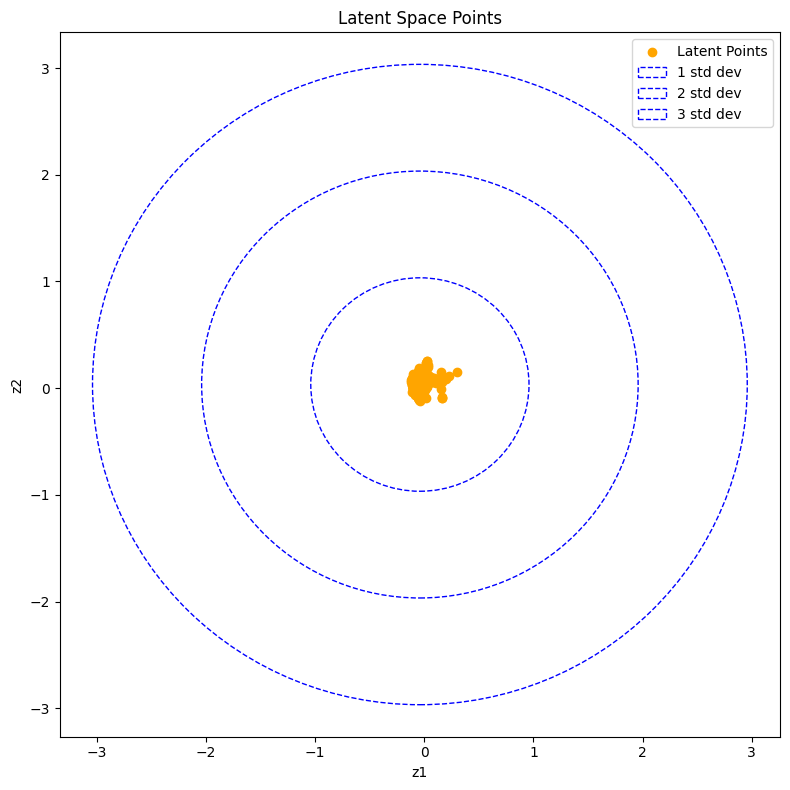

In [ ]:
# plot the point distribution in the latent space



if model_type == "VAE":
    # Get the latent space representation of the test data
    latent_space = []
    for idx, data in enumerate(test_loader):
        x = data[0].to(device)
        x = x.view(x.size(0), -1)
        mean, logvar = loaded_model.encode(x)
        z = loaded_model.reparameterization(mean, logvar)
        latent_space.append(z.cpu().detach().numpy())
    latent_space = np.concatenate(latent_space, axis=0)
    print("Latent space shape:", latent_space.shape)

    # Calculate and print the mean and variance of the latent space points
    latent_mean = np.mean(latent_space, axis=0)
    latent_var = np.var(latent_space, axis=0)
    print("Latent space mean:", latent_mean)
    print("Latent space variance:", latent_var)

    # Plot the latent space in 2D
    fig, ax = plt.subplots()
    # set figuresize
    fig.set_size_inches(8, 8)
    ax.scatter(latent_space[:, 0], latent_space[:, 1], c='orange', label='Latent Points')

    # Add circles for 1, 2, and 3 standard deviations
    for std_dev in range(1, 4):
        circle = patches.Circle(latent_mean, std_dev, edgecolor='blue', facecolor='none', linestyle='--', label=f'{std_dev} std dev')
        ax.add_patch(circle)

    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Points')
    plt.legend()
    plt.tight_layout()
    #save the plot
    plt.savefig(os.path.join(save_model_location, 'surface_latent_space.png'))
    print("Saved the latent space plot to: ", os.path.join(save_model_location, 'surface_latent_space.png'))
    plt.show()
